In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project/metadata (2).csv
/kaggle/input/project/abundances (2).xlsx


**Training of a model**
* This document shows chronologically (most of) the steps we went through to create the final model at the end of the document
* this is why code is often repeated, but was left in to showcase our thoughtprocess, decisions and evolution on how we came to the final model

**Log regression**
* we started out with a linear regression model 

* load in data sets
* delete patients that dont have matched tumor and healthy sample (3 patients)
* calculate ratio in protein expression between matched tumor and healthy sample per patient and protein
* merge the outcome of the expression ratio with the outcome recurrence status from the metadata.
* missing values are imputed with median
* data is split in to test and train data
* due to class imbalance (Class 0: 61 samples (62.24%), Class 1: 37 samples (37.76%)) class weights = 'balanced' is used.
* data is scaled and model is trained and tested

* the performance of this version of the model was compared using class weight = 'balanced' parameter and the SMOTE function for class imbalance. this was also done for  decision three and random forest model (code not in this document). lineair regression model with class weight = 'balanced' had the best performance. (and this is why from now on we coded with this model) 

In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
merged_df = ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

# Separate features (protein ratios) and target (Recurr_status)
X = merged_df.drop(columns=['Recurr_status'])  # Drop the target column
y = merged_df['Recurr_status']                # Target variable

# Remove the Patient_ID column from features
X = X.drop(columns=['Patient_ID'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Impute missing values in X with the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Calculate class imbalance
class_counts = y.value_counts()
total_samples = len(y)
class_imbalance = (class_counts / total_samples) * 100

print("Class Imbalance:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples ({class_imbalance[cls]:.2f}%)")

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model with class weights
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

print("\nClassification Report (Using Class Weights):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Using Class Weights):")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score (Using Class Weights):", accuracy_score(y_test, y_pred))

Class Imbalance:
Class 0: 61 samples (62.24%)
Class 1: 37 samples (37.76%)

Classification Report (Using Class Weights):
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.33      0.20      0.25         5

    accuracy                           0.70        20
   macro avg       0.55      0.53      0.53        20
weighted avg       0.66      0.70      0.67        20

Confusion Matrix (Using Class Weights):
[[13  2]
 [ 4  1]]
Accuracy Score (Using Class Weights): 0.7


**model needs optimalisation for outcome 2**

**check table **

In [2]:
merged_df

,Patient_ID,STBD1,HPD,GSTZ1,ADH1B,GPD1,PHYKPL,ASPDH,DMGDH,FMO3,...,GLDC,PHYH,ATPAF1,DCAKD,RGN,SCO2,ACOT8,COQ3,TMEM245,Recurr_status
0,L076,1.994329,0.270246,0.560694,2.088795,1.661566,0.923269,0.362712,0.432275,0.716727,...,1.782068,1.775315,0.544965,0.415538,1.151860,2.438713,8.093244,NaN,NaN,1
1,L057,1.888218,0.733746,0.737107,1.273745,0.812609,0.763448,0.637852,1.136356,2.078608,...,0.428568,0.998131,2.320889,1.282868,0.926258,0.707507,1.736628,1.270009,2.490519,1
2,L058,1.588110,0.622225,0.274530,0.420113,0.701164,1.273416,0.552412,0.321088,0.865141,...,2.061837,0.365784,1.465793,0.575029,0.453269,1.227361,2.665243,0.964604,1.418871,0
3,L066,1.441408,1.346855,0.550404,0.764171,0.729915,0.620556,0.310430,0.586330,1.631543,...,0.004680,1.172712,0.927498,7.470065,1.051874,0.344052,1.506546,0.824048,4.195782,0
4,L063,0.838275,1.629300,0.703096,0.904632,0.725431,0.117736,1.031828,1.933261,2.237035,...,0.242072,1.388131,1.950291,30.986248,0.651220,1.731400,12.440733,1.049824,1.003996,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,L090,0.029838,0.037286,0.126155,0.104855,0.040498,0.079924,0.009310,0.037900,0.053667,...,0.035112,0.031342,0.481233,0.800000,0.042976,0.112042,7.549518,0.149894,0.440858,1
94,L098,0.405969,0.079932,0.115452,0.113292,0.078828,0.045400,0.023187,0.111160,0.155265,...,0.187187,0.140630,0.408834,0.677530,0.328631,3.486407,5.976406,0.653034,0.984506,1
95,L102,0.013380,0.027731,0.101136,0.072883,0.010122,0.127293,0.020245,0.000331,0.056283,...,0.029469,0.037675,0.206479,1.387778,0.093745,1.014869,0.315892,0.117405,1.762460,0
96,L104,0.373072,0.284405,0.086838,0.461432,0.286587,0.099543,0.192559,0.126484,0.321039,...,0.291334,0.346047,0.880538,0.243037,0.305537,1.449701,1.509740,0.513871,0.924502,0


**log regression**
* optimal hyperparameters are defined via GridSearchCV
* ==> using hyperparameters the performance of the model improves, yet perfomance is still low for class 2.

In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
merged_df = ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

# Separate features (protein ratios) and target (Recurr_status)
X = merged_df.drop(columns=['Recurr_status'])  # Drop the target column
y = merged_df['Recurr_status']                # Target variable

# Remove the Patient_ID column from features
X = X.drop(columns=['Patient_ID'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Impute missing values in X with the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500]
}

# logistic regression (with class_weight = 'balanced') outperformed decison tree, XGBoost and random forest with SMOTE for class imbalance. class weight> smote for lin regression
# Create a logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)

#
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Prediction and evaluation on the test set
y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred))
print("Confusion Matrix (Best Model):")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score (Best Model):", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.48666666666666664

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.40      0.40      0.40         5

    accuracy                           0.70        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.70      0.70      0.70        20

Confusion Matrix (Best Model):
[[12  3]
 [ 3  2]]
Accuracy Score (Best Model): 0.7


**Missing values**
* up until here no proteins were excluded based on too much missing data
* the percentage missing values per protein is visualized using a box plot ==> many proteins have high % missing values, simple imputing with median is not sufficient
* a treshold should be set for the percentage of missing values that is allowed per protein to be left in for the model training
  1. leaving in proteins with too much missing values (that are imputed with median) negatively influences the true performance of the model
  2. leaving out too much proteins; a very low treshold (for example 0-1%) could leave out proteins that are important for the classification task but have high missing values due to the methods used for the data collections. what proteins these are, is not known in advance
* based on point 1, a maximum value of 20% is taken
* for correct handling of point 2, the data collection method (is there a reason a certain protein is not detected with the used measurement methods, is the detection threshold to high? is there acorrelation between missing value and recurrence outcome?...) should be analyzed per protein individually to see why values are missing. This way 'important' proteins for the classification task could be left in even if they have missing values higher than the threshold, due to their importance in the classification


* We acknowledge that cleaning up the datasets is needed (and often 90% of the workload) for training of an optimal model. For the sake of simplicity the performance of three different models will be analyzed at different missing data threshold percentages. the 'why' behind missing values is not looked at further. And the importance of each protein for the classification task is not evaluated, exclusion of proteins in the data set is thus solely based on percentage missing values. 

* percentage missing values of all proteins is visualized using a box plot.
* the maximum cutoff was manually set at 20% and visualized using a red line

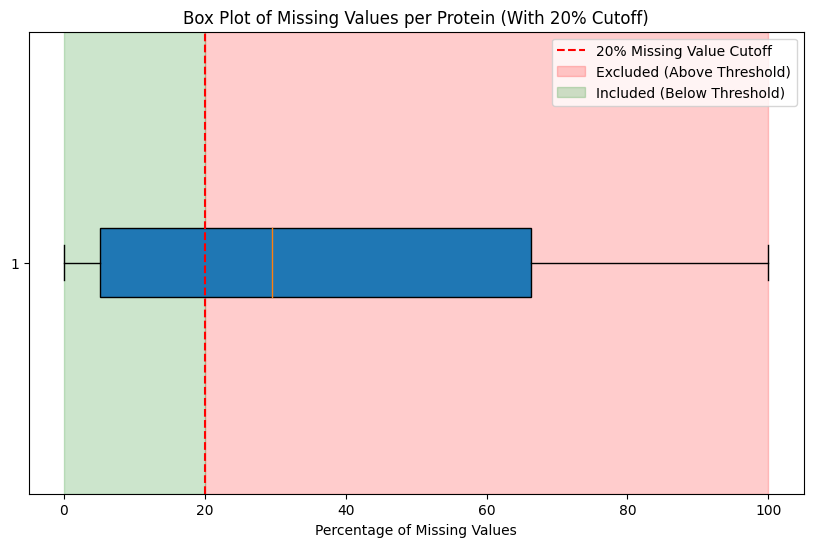

The cutoff for missing values is set at 20.00%


In [4]:
# Set cutoff at 20%
cutoff = 20

# Box plot with cutoff line and visual area distinction
plt.figure(figsize=(10, 6))

# Box plot
plt.boxplot(missing_percentages, vert=False, patch_artist=True)

# Cutoff line
plt.axvline(cutoff, color='red', linestyle='--', label=f"20% Missing Value Cutoff")

# Highlight areas above and below the threshold
plt.fill_betweenx(y=[0.5, 1.5], x1=cutoff, x2=max(missing_percentages), color='red', alpha=0.2, label="Excluded (Above Threshold)")
plt.fill_betweenx(y=[0.5, 1.5], x1=0, x2=cutoff, color='green', alpha=0.2, label="Included (Below Threshold)")

# Add labels and title
plt.title("Box Plot of Missing Values per Protein (With 20% Cutoff)")
plt.xlabel("Percentage of Missing Values")
plt.legend()
plt.show()

# Display the cutoff value
print(f"The cutoff for missing values is set at {cutoff:.2f}%")

**Defining the right model type and treshold**
* the three blocks of code below trains the model using different thresholds for percentage missing values
* all thresholds are tested from 0-20% with increments of 1%
* the performance for each threshold is visualized
* the percentage at wich the accuracy of the model is the highest is visualized using a red striped line

**Linear regression model**
* the model is trained as before
* this time 20 times for each cutoff value
* 16% is the optimal threshold for the linear regression model with the highest accuracy score

Results of F1 Scores and Accuracy for Different Thresholds:
    Threshold  F1_Class_0  F1_Class_1  Accuracy
0         0.0    0.827586    0.545455      0.75
1         1.0    0.827586    0.545455      0.75
2         2.0    0.740741    0.461538      0.65
3         3.0    0.814815    0.615385      0.75
4         4.0    0.814815    0.615385      0.75
5         5.0    0.785714    0.500000      0.70
6         6.0    0.785714    0.500000      0.70
7         7.0    0.720000    0.533333      0.65
8         8.0    0.769231    0.571429      0.70
9         9.0    0.740741    0.461538      0.65
10       10.0    0.827586    0.545455      0.75
11       11.0    0.785714    0.500000      0.70
12       12.0    0.827586    0.545455      0.75
13       13.0    0.785714    0.500000      0.70
14       14.0    0.785714    0.500000      0.70
15       15.0    0.827586    0.545455      0.75
16       16.0    0.903226    0.666667      0.85
17       17.0    0.875000    0.500000      0.80
18       18.0    0.838710   

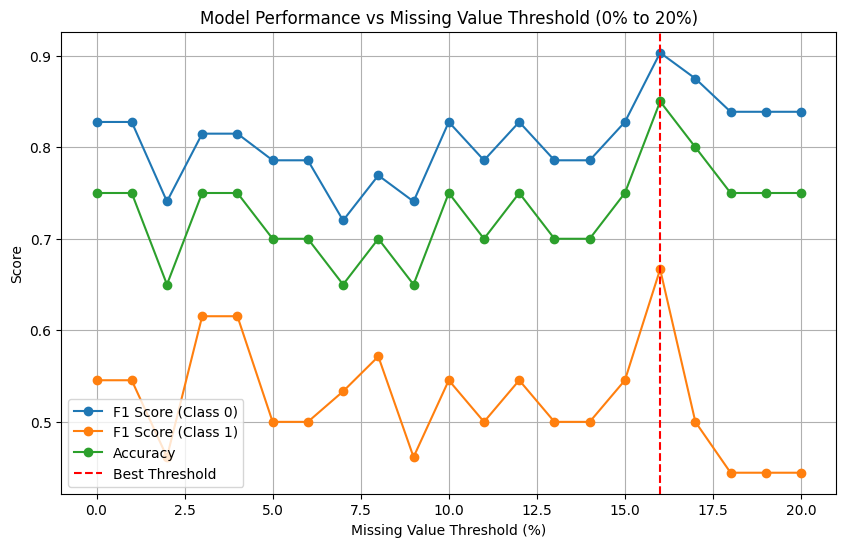

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Compute ratios for each matched patient
for healthy_col in healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    if tumor_col in abundance_df.columns:
        patient_id = healthy_col[:-1]
        abundance_df[f'ratio_{patient_id}'] = (
            abundance_df[tumor_col] / abundance_df[healthy_col]
        ).replace([float('inf'), -float('inf')], pd.NA)

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
results = []

# Loop over thresholds for missing values (0% to 20% with 1% increments)
for threshold in np.arange(0, 20.1, 1.0):
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'max_iter': [100, 200, 500]
    }

    # Create a logistic regression model
    model = LogisticRegression(class_weight='balanced', random_state=42)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Perform the grid search
    grid_search.fit(X_train_scaled, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_scaled, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test_scaled)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'Threshold': threshold,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Thresholds:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Threshold'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold'], color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Missing Value Threshold (%)")
plt.ylabel("Score")
plt.title("Model Performance vs Missing Value Threshold (0% to 20%)")
plt.legend()
plt.grid()
plt.show()

**Decision three model**
* the same is done for the decision three model
* 4% is the optimal threshold for the linear regression model with the highest accuracy score

Results of F1 Scores and Accuracy for Different Thresholds:
    Threshold  F1_Class_0  F1_Class_1  Accuracy
0         0.0    0.642857    0.166667      0.50
1         1.0    0.642857    0.166667      0.50
2         2.0    0.758621    0.363636      0.65
3         3.0    0.583333    0.375000      0.50
4         4.0    0.769231    0.571429      0.70
5         5.0    0.545455    0.444444      0.50
6         6.0    0.500000    0.250000      0.40
7         7.0    0.758621    0.363636      0.65
8         8.0    0.666667    0.307692      0.55
9         9.0    0.666667    0.307692      0.55
10       10.0    0.714286    0.333333      0.60
11       11.0    0.615385    0.285714      0.50
12       12.0    0.615385    0.285714      0.50
13       13.0    0.666667    0.307692      0.55
14       14.0    0.666667    0.307692      0.55
15       15.0    0.615385    0.285714      0.50
16       16.0    0.720000    0.533333      0.65
17       17.0    0.774194    0.222222      0.65
18       18.0    0.812500   

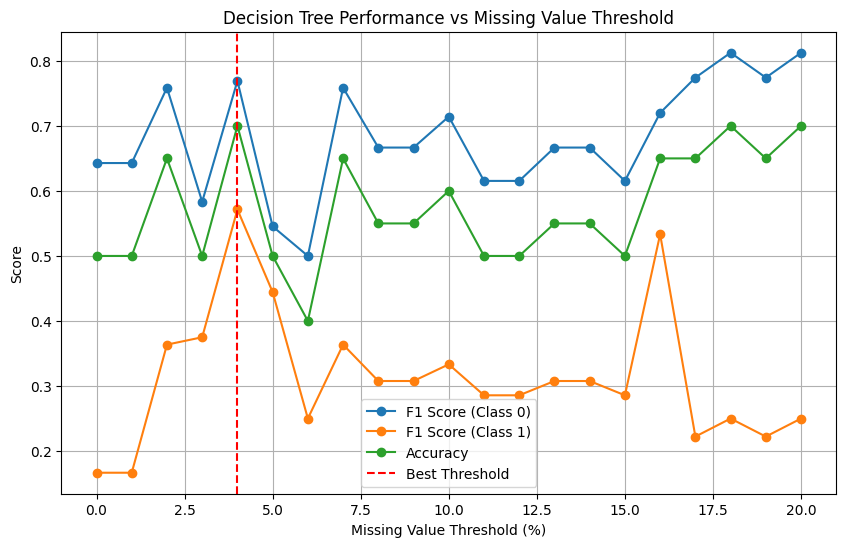

In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})

# Initialize storage for results
results = []

# Loop over thresholds for missing values
for threshold in np.arange(0, 20.1, 1):
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning using GridSearchCV for Decision Tree
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    # Create a decision tree classifier
    model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'Threshold': threshold,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Thresholds:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Threshold'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold'], color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Missing Value Threshold (%)")
plt.ylabel("Score")
plt.title("Decision Tree Performance vs Missing Value Threshold")
plt.legend()
plt.grid()
plt.show()

**Random Forest model**
* the same is done for the random forest model
* 6% is the optimal threshold for the linear regression model with the highest accuracy score

Results of F1 Scores and Accuracy for Different Thresholds:
    Threshold  F1_Class_0  F1_Class_1  Accuracy
0         0.0    0.758621    0.363636      0.65
1         1.0    0.758621    0.363636      0.65
2         2.0    0.709677    0.000000      0.55
3         3.0    0.750000    0.000000      0.60
4         4.0    0.733333    0.200000      0.60
5         5.0    0.774194    0.222222      0.65
6         6.0    0.800000    0.400000      0.70
7         7.0    0.709677    0.000000      0.55
8         8.0    0.774194    0.222222      0.65
9         9.0    0.750000    0.000000      0.60
10       10.0    0.733333    0.200000      0.60
11       11.0    0.787879    0.000000      0.65
12       12.0    0.750000    0.000000      0.60
13       13.0    0.787879    0.000000      0.65
14       14.0    0.787879    0.000000      0.65
15       15.0    0.787879    0.000000      0.65
16       16.0    0.787879    0.000000      0.65
17       17.0    0.787879    0.000000      0.65
18       18.0    0.787879   

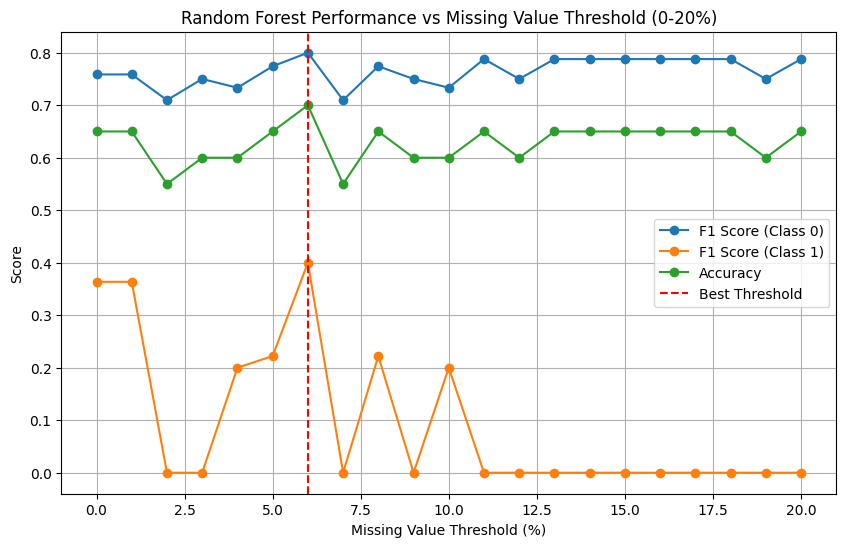

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})

# Initialize storage for results
results = []

# Loop over thresholds for missing values (0% to 20% in 1% increments)
for threshold in np.arange(0, 20.1, 1):
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning using GridSearchCV for Random Forest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'class_weight': ['balanced']
    }

    # Create a random forest classifier
    model = RandomForestClassifier(random_state=42)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'Threshold': threshold,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Thresholds:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Threshold'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold'], color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Missing Value Threshold (%)")
plt.ylabel("Score")
plt.title("Random Forest Performance vs Missing Value Threshold (0-20%)")
plt.legend()
plt.grid()
plt.show()

**training of optimal model using liniear regression model**

* linear regression model had best performance out of the three models tested with an accuracy score of 0.85, F1: 0,9 and F2: 0,67 for simplicity we only test following adaptations for model optimalisation on the linear regression model.
* class imbalance is corrected for using class weights
* optimal hyperparameters are calculated via GridSearchCV and implemented
* features (= proteins) with missing data higher than 16% is left out
* missing data is imputed using median
* the ideal amount of features (between 10 and 50) is selected at the  16% missing value threshold. best features are kept



Results of F1 Scores and Accuracy for Different Numbers of Features:
    Num_Features  F1_Class_0  F1_Class_1  Accuracy  \
0             10    0.740741    0.461538      0.65   
1             11    0.857143    0.666667      0.80   
2             12    0.740741    0.461538      0.65   
3             13    0.740741    0.461538      0.65   
4             14    0.740741    0.461538      0.65   
5             15    0.769231    0.571429      0.70   
6             16    0.827586    0.545455      0.75   
7             17    0.785714    0.500000      0.70   
8             18    0.785714    0.500000      0.70   
9             19    0.785714    0.500000      0.70   
10            20    0.785714    0.500000      0.70   
11            21    0.785714    0.500000      0.70   
12            22    0.827586    0.545455      0.75   
13            23    0.827586    0.545455      0.75   
14            24    0.827586    0.545455      0.75   
15            25    0.827586    0.545455      0.75   
16           

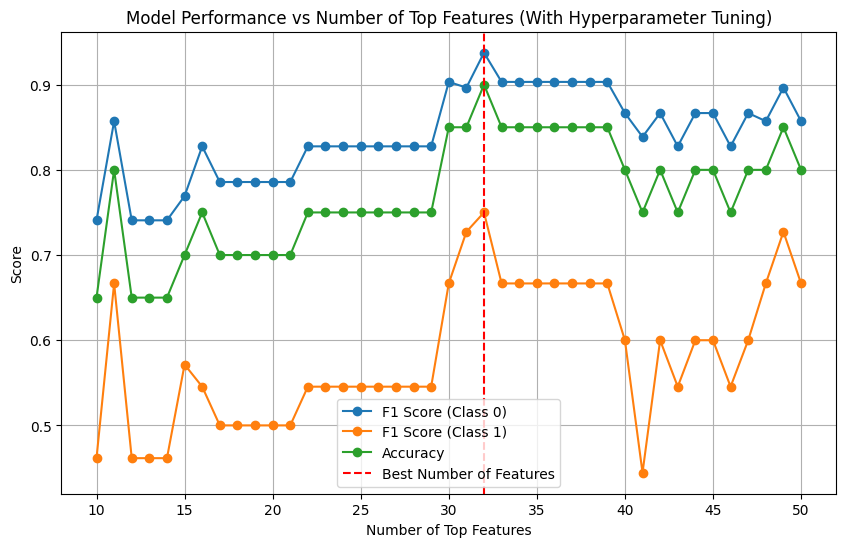

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Compute ratios for each matched patient
for healthy_col in healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    if tumor_col in abundance_df.columns:
        patient_id = healthy_col[:-1]
        abundance_df[f'ratio_{patient_id}'] = (
            abundance_df[tumor_col] / abundance_df[healthy_col]
        ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Filter out proteins with more than 15% missing values
threshold = 15
missing_percentages = ratio_df.isnull().mean() * 100
filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

# Separate features (protein ratios) and target (Recurr_status)
X = merged_df.drop(columns=['Recurr_status'])  # Drop the target column
y = merged_df['Recurr_status']                # Target variable

# Remove the Patient_ID column from features
X = X.drop(columns=['Patient_ID'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Impute missing values in X with the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Initialize storage for results
results = []

# Rank proteins by importance and loop through subsets
for num_features in range(10, 51, 1):  # Test 10 to 50 most important proteins
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train logistic regression model on all features to determine importance
    model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=200)
    model.fit(X_train_scaled, y_train)
    feature_importance = np.abs(model.coef_[0])

    # Rank features by importance
    ranked_features_indices = np.argsort(feature_importance)[::-1]
    top_features_indices = ranked_features_indices[:num_features]

    # Filter data to include only the top-ranked features
    X_train_reduced = X_train_scaled[:, top_features_indices]
    X_test_reduced = X_test_scaled[:, top_features_indices]

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'],
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_train_reduced, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_reduced, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test_reduced)

    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the results
    results.append({
        'Num_Features': num_features,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy,
        'Best_Parameters': grid_search.best_params_
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Numbers of Features:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Num_Features'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Num_Features'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Num_Features'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Num_Features'], color='red', linestyle='--', label='Best Number of Features')
plt.xlabel("Number of Top Features")
plt.ylabel("Score")
plt.title("Model Performance vs Number of Top Features (With Hyperparameter Tuning)")
plt.legend()
plt.grid()
plt.show()

**shortcomings code above**
* the hardcoded 16% %missing value threshold was determined without taking in to consideration model performance trained on only the best features
* code below tries to fix this

**optimized workflow for linear regression model + selection of best model parameters**

1.	Filter Proteins by Missing Value Threshold:
	•	The code iteratively filters out proteins with more than a specific percentage of missing values, ranging from 0% to 20% in 1% increments.
2.	Rank Features by Importance for Each Threshold:
	•	For each threshold, it trains a logistic regression model on the dataset filtered by missing value percentage and calculates the absolute values of the coefficients (model.coef_) to determine the importance of each protein (feature).
	•	The features are then ranked based on their importance.
3.	Iterative Training for Most Important Proteins:
	•	For each threshold, the code selects the top 1 to 50 most important proteins (based on their importance ranking).
	•	It trains the logistic regression model on subsets of the top-ranked features and evaluates their performance.
4.	Hyperparameter Tuning:
	•	For each subset of the top-ranked proteins, it performs hyperparameter optimization using GridSearchCV to find the best combination of regularization strength (C), solver (liblinear or lbfgs), and penalty (l2).
5.	Model Training and Evaluation:
	•	Using the best hyperparameters from GridSearchCV, the code trains the logistic regression model on the subset of features and evaluates its performance using accuracy and F1 scores for each class.
6.	Track Best-Performing Models:
	•	The code keeps track of the best-performing models across all thresholds and feature subsets in terms of accuracy. If multiple models achieve the same highest accuracy, all of them are stored as candidates.
7.	Visualization of Performance:
	•	The code visualizes accuracy for all feature subsets (1 to 50 proteins) for different missing value thresholds in four plots. Each plot corresponds to a threshold range (e.g., 0-5%, 5-10%, etc.).
8.	Save and Report Best Model:
	•	Among the best-performing models, the first one is saved using joblib. The details (threshold, number of features, accuracy, F1 scores) of all top-performing models are printed.


**Results**
* the best linear regression model for this dataset is trained with leaving out all data with more than 18% missing values and using the best 26 features (= proteins).
* this gives a model with an accuracy of 96% and F1 score of 0.968 and 0.889 for class 0 and 1 respectively

* 


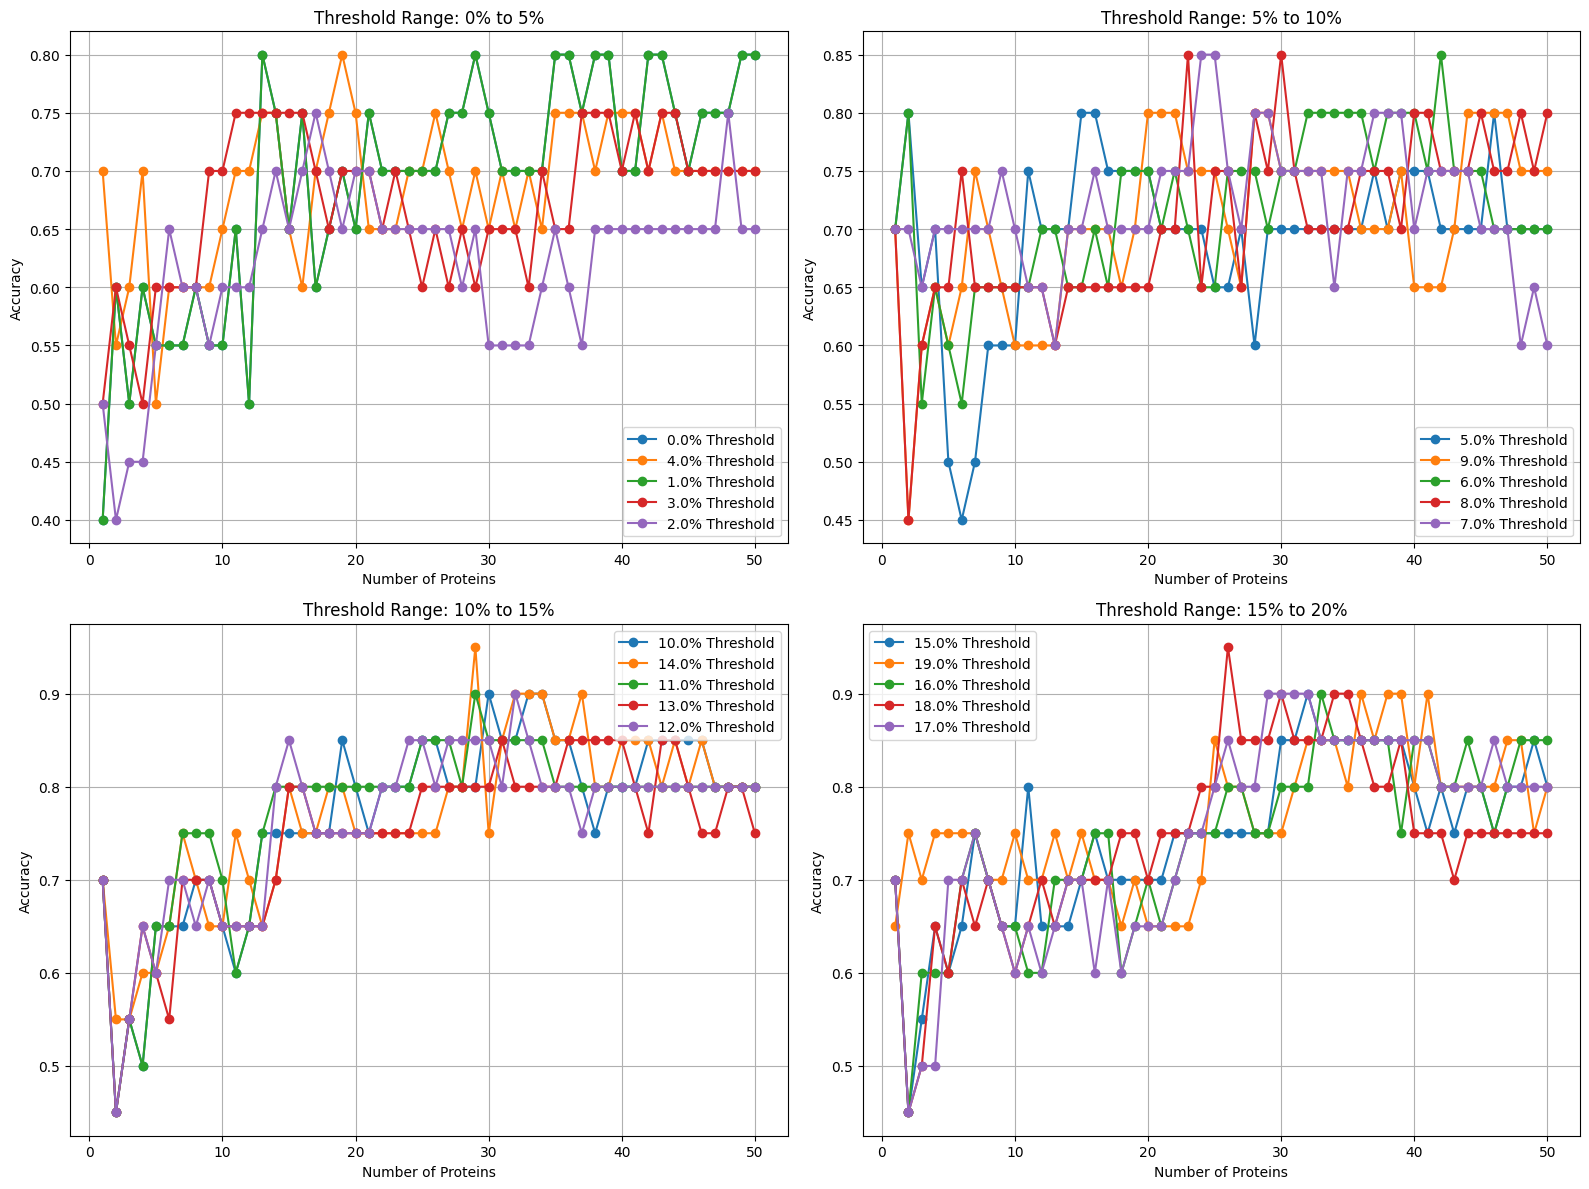

Best Model Candidates:
Threshold: 18.0%, Num Features: 26, Accuracy: 0.95, F1_Class_0: 0.967741935483871, F1_Class_1: 0.888888888888889

Final Model Selected: Threshold=18.0%, Num Features=26, Accuracy=0.95, F1_Class_0=0.967741935483871, F1_Class_1=0.888888888888889


In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import joblib

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Compute ratios for each matched patient
for healthy_col in healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    if tumor_col in abundance_df.columns:
        patient_id = healthy_col[:-1]
        abundance_df[f'ratio_{patient_id}'] = (
            abundance_df[tumor_col] / abundance_df[healthy_col]
        ).replace([float('inf'), -float('inf')], pd.NA)

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
results = []
best_model_candidates = []
best_performance = -np.inf

# Loop over thresholds for missing values (0% to 20% with 1% increments)
thresholds = np.arange(0, 20.1, 1.0)
for threshold in thresholds:
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature importance evaluation using Logistic Regression
    model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=200)
    model.fit(X_train_scaled, y_train)
    
    # Use coefficients to determine feature importance
    importance = np.abs(model.coef_[0])
    feature_indices_sorted = np.argsort(importance)[::-1]

    # Loop over subsets of the most important features (1 to 50)
    for num_features in range(1, 51):
        top_indices = feature_indices_sorted[:num_features]
        X_train_subset = X_train_scaled[:, top_indices]
        X_test_subset = X_test_scaled[:, top_indices]

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear'],
            'penalty': ['l2'],
        }

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            verbose=0,
            n_jobs=-1
        )

        grid_search.fit(X_train_subset, y_train)

        # Train the best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_subset, y_train)

        # Predictions and metrics
        y_pred = best_model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
        f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

        # Store the results
        results.append({
            'Threshold': threshold,
            'Num_Features': num_features,
            'Accuracy': accuracy,
            'F1_Class_0': f1_class_0,
            'F1_Class_1': f1_class_1
        })

        # Track the best-performing models, prefer fewer features for ties
        if accuracy > best_performance:
            best_performance = accuracy
            best_model_candidates = [{
                'model': best_model,
                'threshold': threshold,
                'num_features': num_features,
                'accuracy': accuracy,
                'f1_class_0': f1_class_0,
                'f1_class_1': f1_class_1
            }]
        elif accuracy == best_performance:
            if not best_model_candidates or num_features < best_model_candidates[0]['num_features']:
                best_model_candidates = [{
                    'model': best_model,
                    'threshold': threshold,
                    'num_features': num_features,
                    'accuracy': accuracy,
                    'f1_class_0': f1_class_0,
                    'f1_class_1': f1_class_1
                }]

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Visualization in 4 plots
plt.figure(figsize=(16, 12))
threshold_ranges = [(0, 5), (5, 10), (10, 15), (15, 20)]
for i, (start, end) in enumerate(threshold_ranges):
    plt.subplot(2, 2, i + 1)
    subset = results_df[(results_df['Threshold'] >= start) & (results_df['Threshold'] < end)].sort_values(by='Num_Features')
    for threshold in subset['Threshold'].unique():
        data = subset[subset['Threshold'] == threshold]
        plt.plot(data['Num_Features'], data['Accuracy'], label=f"{threshold}% Threshold", marker='o')
    plt.title(f"Threshold Range: {start}% to {end}%")
    plt.xlabel("Number of Proteins")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

# Print all best model candidates
print("Best Model Candidates:")
for candidate in best_model_candidates:
    print(f"Threshold: {candidate['threshold']}%, Num Features: {candidate['num_features']}, "
          f"Accuracy: {candidate['accuracy']}, F1_Class_0: {candidate['f1_class_0']}, F1_Class_1: {candidate['f1_class_1']}")

# Save the first model among the best-performing ones
final_model = best_model_candidates[0]['model']
joblib.dump(final_model, 'best_model.pkl')

# Visualization of the final model's performance
print(f"\nFinal Model Selected: Threshold={best_model_candidates[0]['threshold']}%, "
      f"Num Features={best_model_candidates[0]['num_features']}, Accuracy={best_model_candidates[0]['accuracy']}, "
      f"F1_Class_0={best_model_candidates[0]['f1_class_0']}, F1_Class_1={best_model_candidates[0]['f1_class_1']}")